In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import seaborn as sns

In [118]:
df = pd.read_csv('data.csv', sep='\t', header=0)

In [119]:
df

,F0,F1,F2
0,d,a,a
1,c,e,c
2,j,a,c
3,f,e,j
4,c,e,d
...,...,...,...
995,d,g,g
996,b,i,f
997,i,g,g
998,d,h,b


In [120]:
# Perform one-hot encoding via pandas.get_dummies to avoid sklearn version issues
df_encoded = pd.get_dummies(df, dtype=int)

# Display the shape and first few rows
print(f"Encoded DataFrame shape: {df_encoded.shape}")
print("First five rows of encoded data:")
display(df_encoded.head())

Encoded DataFrame shape: (1000, 30)
First five rows of encoded data:


,F0_a,F0_b,F0_c,F0_d,F0_e,F0_f,F0_g,F0_h,F0_i,F0_j,...,F2_a,F2_b,F2_c,F2_d,F2_e,F2_f,F2_g,F2_h,F2_i,F2_j
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [121]:
def compute_bpi(labels):
    counts = np.bincount(labels)
    if len(counts) <= 1:
        return 0.0
    std_dev = np.std(counts)
    mean = np.mean(counts)
    return max(0.0, 1 - std_dev / mean)


In [122]:
n_clusters = [*range(2,11)]
results_km = pd.DataFrame(columns=['n_clusters', 'inertia', 'silhouette_score', 'bpi'])

for n in n_clusters:
    cluster_km = KMeans(n_clusters=n)
    lbls_km = cluster_km.fit_predict(df_encoded)
    inertia = cluster_km.inertia_
    ss = silhouette_score(df_encoded,lbls_km)
    bpi =compute_bpi(lbls_km)
    results_km.loc[len(results_km)] = [n, inertia, ss, bpi]


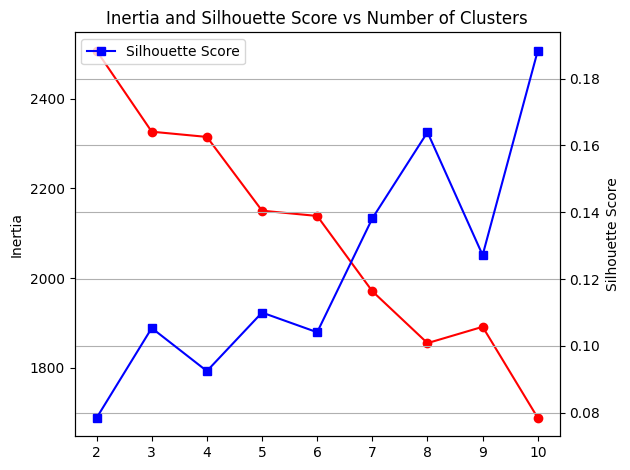

In [123]:
# Plot 1: Inertia and Silhouette Score
ax1 = plt.subplot()
ax1.plot(results_km['n_clusters'], results_km['inertia'], marker='o', label='Inertia', color='red')
ax1.set_ylabel('Inertia')
ax2 = ax1.twinx()
ax2.plot(results_km['n_clusters'], results_km['silhouette_score'], marker='s', label='Silhouette Score', color='blue')
ax2.set_ylabel('Silhouette Score')
plt.title('Inertia and Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

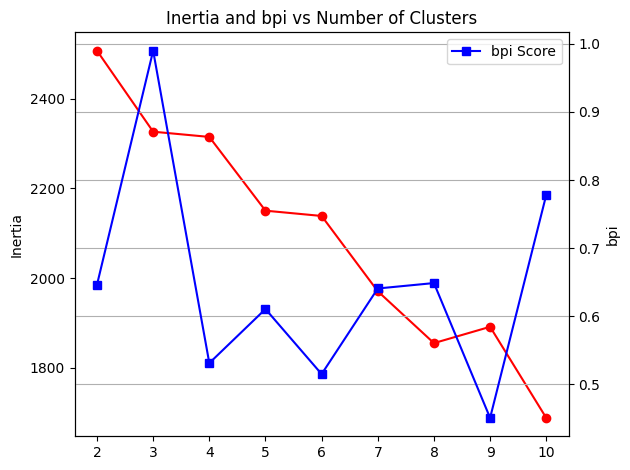

In [124]:
# Plot 1: Inertia and Silhouette Score
ax1 = plt.subplot()
ax1.plot(results_km['n_clusters'], results_km['inertia'], marker='o', label='Inertia', color='red')
ax1.set_ylabel('Inertia')
ax2 = ax1.twinx()
ax2.plot(results_km['n_clusters'], results_km['bpi'], marker='s', label='bpi Score', color='blue')
ax2.set_ylabel('bpi')
plt.title('Inertia and bpi vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
best_params_km = {'n_clusters': 3}
best_cluster_km = KMeans(**best_params_km)
best_lbls_km = best_cluster_km.fit_predict(df_encoded)

In [126]:
n_clusters = [*range(2,11)]
linkage = ['ward', 'average', 'complete', 'single']
params = {'n_clusters': n_clusters, 'linkage': linkage}
results_ag = pd.DataFrame(columns=['n_clusters', 'linkage', 'silhouette_score', 'bpi'])
params = list(ParameterGrid(params))
for i in params:
    cluster_ag = AgglomerativeClustering(**i)
    lbls_ag = cluster_ag.fit_predict(df_encoded)
    ss = silhouette_score(df_encoded, lbls_ag)
    bpi = compute_bpi(lbls_ag)
    results_ag.loc[len(results_ag)] = [i['n_clusters'], i['linkage'], ss, bpi]

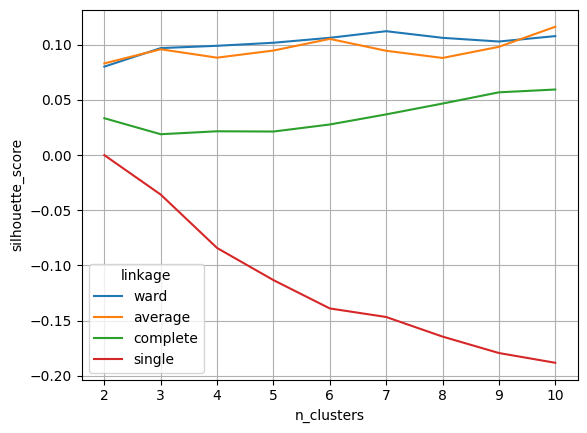

In [127]:
sns.lineplot(data = results_ag, x = 'n_clusters', y = 'silhouette_score', hue='linkage')
plt.grid()
plt.show()

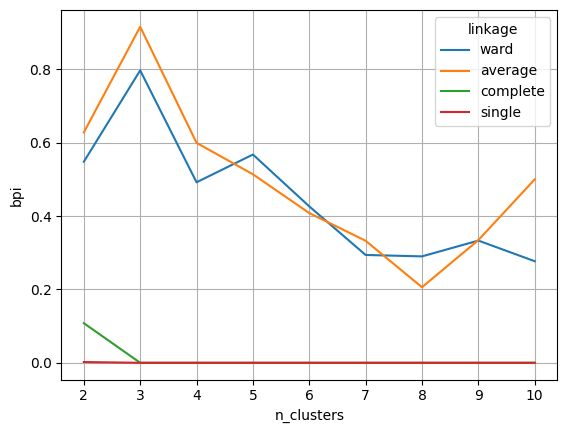

In [128]:
sns.lineplot(data=results_ag, x='n_clusters', y='bpi', hue='linkage')
plt.grid()
plt.show()

In [129]:
best_params_ag = {'n_clusters': 3, 'linkage': 'ward'}
best_cluster_ag = AgglomerativeClustering(**best_params_ag)
best_lbls_ag = best_cluster_ag.fit_predict(df_encoded)

In [130]:
eps = np.arange(0.2,1.5,0.1)
min_samples = np.arange(3,20,1)
params = {'eps': eps, 'min_samples': min_samples}
params = list(ParameterGrid(params))
results_db = pd.DataFrame(columns = ['eps', 'min_samples', 'silhouette_score', 'uncluster', 'bpi'])
for i in params:
    cluster_db = DBSCAN(**i)
    lbls_db = cluster_db.fit_predict(df_encoded)
    unclustered = np.sum(lbls_db == -1)
    clustered_mask = lbls_db != -1
    clustered_lbls = lbls_db[clustered_mask]
    
    if len(np.unique(clustered_lbls)) > 1:
        ss = silhouette_score(df_encoded[clustered_mask], clustered_lbls)
        bpi = compute_bpi(clustered_lbls) 
    else:
        ss = np.nan
        bpi = np.nan

    results_db.loc[len(results_db)] = [i['eps'], i['min_samples'], ss, unclustered, bpi]
